BERT的AE倒序裁剪

In [2]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner
from tqdm import tqdm

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)

# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")


In [3]:
def get_new_head_mask_basedonAE(head_mask_previous,AE_matrix):
    selected_matrix = head_mask_previous * (AE_matrix.max()-AE_matrix)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,device='cuda'):
    total = 0
    right = 0
    model.to(device)
    for data in ds['train']:
        inputs = tokenizer(data['Title'],return_tensors='pt').to(device)
        outputs = model(**inputs)
        total  += 1
        if torch.max(outputs[0][0].softmax(0),dim=0).indices==data['labels']:
            right += 1
    return right/total
def prune_based_on_AE(ds,model,tokenizer,AE_matrix):
    head_mask = torch.tensor([[1]*12]*12)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(144)):
        head_mask = get_new_head_mask_basedonAE(head_mask,AE_matrix)
        model.to('cuda')
        pruner.prune(head_mask=head_mask,save_model=False)
        print('head_mask',head_mask)
        acc_score = get_acc(ds,model,tokenizer)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [4]:
BERT_AE_matrix = torch.load('D:\\research\\research4\\BERT_AE - rectified - rectified\\BERT_2329AE.pt')

C:\Users\m1830\AppData\Local\Temp\ipykernel_18152\1981432342.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  BERT_AE_matrix = torch.load('D:\\research\\research4\\BERT_A

In [5]:
BERT_AE_accs = prune_based_on_AE(ds,model,tokenizer,BERT_AE_matrix)

pruned heads: 0 acc: 0.9682267067410906


  0%|          | 0/144 [00:00<?, ?it/s]

head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  1%|          | 1/144 [00:13<31:49, 13.36s/it]

pruned heads: 1 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  1%|▏         | 2/144 [00:26<31:34, 13.34s/it]

pruned heads: 2 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  2%|▏         | 3/144 [00:40<31:30, 13.41s/it]

pruned heads: 3 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  3%|▎         | 4/144 [00:53<31:21, 13.44s/it]

pruned heads: 4 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  3%|▎         | 5/144 [01:06<30:46, 13.28s/it]

pruned heads: 5 acc: 0.9677973379132675
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  4%|▍         | 6/144 [01:19<30:07, 13.10s/it]

pruned heads: 6 acc: 0.9677973379132675
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  5%|▍         | 7/144 [01:32<29:38, 12.98s/it]

pruned heads: 7 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  6%|▌         | 8/144 [01:46<30:13, 13.34s/it]

pruned heads: 8 acc: 0.9682267067410906
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  6%|▋         | 9/144 [01:59<29:39, 13.18s/it]

pruned heads: 9 acc: 0.9677973379132675
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  7%|▋         | 10/144 [02:11<28:49, 12.91s/it]

pruned heads: 10 acc: 0.9677973379132675
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  8%|▊         | 11/144 [02:23<28:21, 12.79s/it]

pruned heads: 11 acc: 0.9677973379132675
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  8%|▊         | 12/144 [02:37<28:33, 12.98s/it]

pruned heads: 12 acc: 0.9682267067410906
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


  9%|▉         | 13/144 [02:51<28:51, 13.22s/it]

pruned heads: 13 acc: 0.9695148132245599
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 10%|▉         | 14/144 [03:04<28:39, 13.23s/it]

pruned heads: 14 acc: 0.9695148132245599
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 10%|█         | 15/144 [03:17<28:17, 13.16s/it]

pruned heads: 15 acc: 0.9695148132245599
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 11%|█         | 16/144 [03:30<27:54, 13.08s/it]

pruned heads: 16 acc: 0.970373550880206
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 12%|█▏        | 17/144 [03:43<27:30, 13.00s/it]

pruned heads: 17 acc: 0.970373550880206
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 12%|█▎        | 18/144 [03:55<27:07, 12.92s/it]

pruned heads: 18 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 13%|█▎        | 19/144 [04:08<26:50, 12.89s/it]

pruned heads: 19 acc: 0.9682267067410906
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 14%|█▍        | 20/144 [04:21<26:29, 12.82s/it]

pruned heads: 20 acc: 0.9682267067410906
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 15%|█▍        | 21/144 [04:33<26:10, 12.77s/it]

pruned heads: 21 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 15%|█▌        | 22/144 [04:46<26:03, 12.82s/it]

pruned heads: 22 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 16%|█▌        | 23/144 [04:59<25:56, 12.87s/it]

pruned heads: 23 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 17%|█▋        | 24/144 [05:12<25:37, 12.81s/it]

pruned heads: 24 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 17%|█▋        | 25/144 [05:25<25:24, 12.81s/it]

pruned heads: 25 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 18%|█▊        | 26/144 [05:38<25:23, 12.91s/it]

pruned heads: 26 acc: 0.9695148132245599
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 19%|█▉        | 27/144 [05:51<25:12, 12.93s/it]

pruned heads: 27 acc: 0.970373550880206
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 19%|█▉        | 28/144 [06:04<25:17, 13.08s/it]

pruned heads: 28 acc: 0.969944182052383
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 20%|██        | 29/144 [06:18<25:31, 13.32s/it]

pruned heads: 29 acc: 0.969944182052383
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 21%|██        | 30/144 [06:32<25:37, 13.49s/it]

pruned heads: 30 acc: 0.970373550880206
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 22%|██▏       | 31/144 [06:46<25:22, 13.47s/it]

pruned heads: 31 acc: 0.970373550880206
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 22%|██▏       | 32/144 [06:59<25:02, 13.42s/it]

pruned heads: 32 acc: 0.969944182052383
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 23%|██▎       | 33/144 [07:11<24:20, 13.16s/it]

pruned heads: 33 acc: 0.969944182052383
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 24%|██▎       | 34/144 [07:24<23:51, 13.01s/it]

pruned heads: 34 acc: 0.969944182052383
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 24%|██▍       | 35/144 [07:37<23:28, 12.92s/it]

pruned heads: 35 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 25%|██▌       | 36/144 [07:50<23:16, 12.93s/it]

pruned heads: 36 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 26%|██▌       | 37/144 [08:03<23:16, 13.05s/it]

pruned heads: 37 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 26%|██▋       | 38/144 [08:17<23:35, 13.35s/it]

pruned heads: 38 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 27%|██▋       | 39/144 [08:31<23:45, 13.58s/it]

pruned heads: 39 acc: 0.9686560755689136
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 28%|██▊       | 40/144 [08:46<24:04, 13.89s/it]

pruned heads: 40 acc: 0.9682267067410906
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 28%|██▊       | 41/144 [09:00<23:55, 13.94s/it]

pruned heads: 41 acc: 0.9682267067410906
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 29%|██▉       | 42/144 [09:13<23:11, 13.64s/it]

pruned heads: 42 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 30%|██▉       | 43/144 [09:26<22:29, 13.36s/it]

pruned heads: 43 acc: 0.9695148132245599
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 31%|███       | 44/144 [09:39<22:08, 13.29s/it]

pruned heads: 44 acc: 0.9690854443967368
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 31%|███▏      | 45/144 [09:52<22:00, 13.34s/it]

pruned heads: 45 acc: 0.9677973379132675
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 32%|███▏      | 46/144 [10:06<21:51, 13.39s/it]

pruned heads: 46 acc: 0.9677973379132675
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 33%|███▎      | 47/144 [10:19<21:27, 13.27s/it]

pruned heads: 47 acc: 0.9665092314297982
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 33%|███▎      | 48/144 [10:32<21:04, 13.17s/it]

pruned heads: 48 acc: 0.965221124946329
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 34%|███▍      | 49/144 [10:45<20:48, 13.14s/it]

pruned heads: 49 acc: 0.9639330184628596
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 35%|███▍      | 50/144 [10:58<20:36, 13.16s/it]

pruned heads: 50 acc: 0.9630742808072134
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 35%|███▌      | 51/144 [11:11<20:17, 13.10s/it]

pruned heads: 51 acc: 0.9635036496350365
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 36%|███▌      | 52/144 [11:24<19:59, 13.04s/it]

pruned heads: 52 acc: 0.9622155431515672
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 37%|███▋      | 53/144 [11:37<19:49, 13.07s/it]

pruned heads: 53 acc: 0.961356805495921
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 38%|███▊      | 54/144 [11:50<19:37, 13.09s/it]

pruned heads: 54 acc: 0.9626449119793903
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 38%|███▊      | 55/144 [12:03<19:19, 13.03s/it]

pruned heads: 55 acc: 0.9622155431515672
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 39%|███▉      | 56/144 [12:16<19:03, 13.00s/it]

pruned heads: 56 acc: 0.9639330184628596
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 40%|███▉      | 57/144 [12:29<18:49, 12.99s/it]

pruned heads: 57 acc: 0.9622155431515672
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 40%|████      | 58/144 [12:42<18:50, 13.14s/it]

pruned heads: 58 acc: 0.961356805495921
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 41%|████      | 59/144 [12:56<18:42, 13.21s/it]

pruned heads: 59 acc: 0.9592099613568055
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 42%|████▏     | 60/144 [13:08<18:21, 13.11s/it]

pruned heads: 60 acc: 0.9579218548733361
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 42%|████▏     | 61/144 [13:22<18:22, 13.28s/it]

pruned heads: 61 acc: 0.9566337483898669
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 43%|████▎     | 62/144 [13:35<17:58, 13.15s/it]

pruned heads: 62 acc: 0.9574924860455131
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 44%|████▍     | 63/144 [13:48<17:40, 13.10s/it]

pruned heads: 63 acc: 0.9583512237011593
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 44%|████▍     | 64/144 [14:01<17:26, 13.09s/it]

pruned heads: 64 acc: 0.944182052382997
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 45%|████▌     | 65/144 [14:14<17:09, 13.03s/it]

pruned heads: 65 acc: 0.9424645770717046
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]])


 46%|████▌     | 66/144 [14:27<16:50, 12.95s/it]

pruned heads: 66 acc: 0.9424645770717046
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]])


 47%|████▋     | 67/144 [14:40<16:52, 13.14s/it]

pruned heads: 67 acc: 0.9446114212108201
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]])


 47%|████▋     | 68/144 [14:53<16:38, 13.14s/it]

pruned heads: 68 acc: 0.944182052382997
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]])


 48%|████▊     | 69/144 [15:06<16:20, 13.08s/it]

pruned heads: 69 acc: 0.9424645770717046
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]])


 49%|████▊     | 70/144 [15:19<15:59, 12.97s/it]

pruned heads: 70 acc: 0.9364534134821811
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]])


 49%|████▉     | 71/144 [15:32<15:49, 13.01s/it]

pruned heads: 71 acc: 0.9377415199656505
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]])


 50%|█████     | 72/144 [15:45<15:34, 12.98s/it]

pruned heads: 72 acc: 0.9407471017604122
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 51%|█████     | 73/144 [15:58<15:21, 12.97s/it]

pruned heads: 73 acc: 0.9390296264491198
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 51%|█████▏    | 74/144 [16:11<15:07, 12.97s/it]

pruned heads: 74 acc: 0.9394589952769429
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 52%|█████▏    | 75/144 [16:24<14:54, 12.97s/it]

pruned heads: 75 acc: 0.9368827823100043
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 53%|█████▎    | 76/144 [16:37<14:43, 12.99s/it]

pruned heads: 76 acc: 0.9261485616144268
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


d:\Python\lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
 53%|█████▎    | 77/144 [16:50<14:27, 12.95s/it]

pruned heads: 77 acc: 0.9252898239587806
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 54%|█████▍    | 78/144 [17:03<14:13, 12.94s/it]

pruned heads: 78 acc: 0.9167024474023185
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 55%|█████▍    | 79/144 [17:15<13:55, 12.86s/it]

pruned heads: 79 acc: 0.909832546157149
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 56%|█████▌    | 80/144 [17:28<13:43, 12.87s/it]

pruned heads: 80 acc: 0.9102619149849721
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 56%|█████▋    | 81/144 [17:41<13:23, 12.75s/it]

pruned heads: 81 acc: 0.9102619149849721
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 57%|█████▋    | 82/144 [17:54<13:13, 12.80s/it]

pruned heads: 82 acc: 0.9136968656075569
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 58%|█████▊    | 83/144 [18:07<13:01, 12.81s/it]

pruned heads: 83 acc: 0.9046801202232718
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]])


 58%|█████▊    | 84/144 [18:20<12:53, 12.89s/it]

pruned heads: 84 acc: 0.9042507513954486
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 59%|█████▉    | 85/144 [18:33<12:40, 12.90s/it]

pruned heads: 85 acc: 0.905968226706741
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 60%|█████▉    | 86/144 [18:45<12:27, 12.88s/it]

pruned heads: 86 acc: 0.9042507513954486
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 60%|██████    | 87/144 [18:58<12:15, 12.90s/it]

pruned heads: 87 acc: 0.9029626449119794
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 61%|██████    | 88/144 [19:11<11:58, 12.82s/it]

pruned heads: 88 acc: 0.896951481322456
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 62%|██████▏   | 89/144 [19:24<11:41, 12.76s/it]

pruned heads: 89 acc: 0.8956633748389867
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 62%|██████▎   | 90/144 [19:37<11:41, 12.98s/it]

pruned heads: 90 acc: 0.884070416487763
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 63%|██████▎   | 91/144 [19:50<11:30, 13.04s/it]

pruned heads: 91 acc: 0.8802060970373551
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 64%|██████▍   | 92/144 [20:03<11:19, 13.06s/it]

pruned heads: 92 acc: 0.8784886217260627
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 65%|██████▍   | 93/144 [20:17<11:16, 13.26s/it]

pruned heads: 93 acc: 0.8763417775869472
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 65%|██████▌   | 94/144 [20:31<11:08, 13.38s/it]

pruned heads: 94 acc: 0.7131816230141692
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 66%|██████▌   | 95/144 [20:44<11:00, 13.47s/it]

pruned heads: 95 acc: 0.7131816230141692
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 67%|██████▋   | 96/144 [20:58<10:53, 13.62s/it]

pruned heads: 96 acc: 0.7007299270072993
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 67%|██████▋   | 97/144 [21:12<10:33, 13.47s/it]

pruned heads: 97 acc: 0.6882782310004294
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 68%|██████▊   | 98/144 [21:24<10:10, 13.27s/it]

pruned heads: 98 acc: 0.7033061399742379
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 69%|██████▉   | 99/144 [21:37<09:50, 13.13s/it]

pruned heads: 99 acc: 0.7054529841133533
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 69%|██████▉   | 100/144 [21:50<09:29, 12.95s/it]

pruned heads: 100 acc: 0.5938170888793474
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 70%|███████   | 101/144 [22:02<09:10, 12.79s/it]

pruned heads: 101 acc: 0.5942464577071704
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 71%|███████   | 102/144 [22:14<08:51, 12.67s/it]

pruned heads: 102 acc: 0.5908115070845856
head_mask tensor([[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 72%|███████▏  | 103/144 [22:27<08:35, 12.57s/it]

pruned heads: 103 acc: 0.5817947617003005
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 72%|███████▏  | 104/144 [22:40<08:28, 12.72s/it]

pruned heads: 104 acc: 0.5744954916273078
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 73%|███████▎  | 105/144 [22:53<08:16, 12.74s/it]

pruned heads: 105 acc: 0.5568913696865607
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 74%|███████▎  | 106/144 [23:05<07:59, 12.62s/it]

pruned heads: 106 acc: 0.5547445255474452
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 74%|███████▍  | 107/144 [23:17<07:42, 12.51s/it]

pruned heads: 107 acc: 0.5521683125805067
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 75%|███████▌  | 108/144 [23:29<07:26, 12.42s/it]

pruned heads: 108 acc: 0.541004723057106
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 76%|███████▌  | 109/144 [23:42<07:10, 12.30s/it]

pruned heads: 109 acc: 0.5405753542292829
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])


 76%|███████▋  | 110/144 [23:54<06:57, 12.28s/it]

pruned heads: 110 acc: 0.5405753542292829
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 77%|███████▋  | 111/144 [24:06<06:42, 12.20s/it]

pruned heads: 111 acc: 0.5384285100901675
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 78%|███████▊  | 112/144 [24:18<06:28, 12.14s/it]

pruned heads: 112 acc: 0.5379991412623444
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 78%|███████▊  | 113/144 [24:30<06:15, 12.13s/it]

pruned heads: 113 acc: 0.5379991412623444
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 79%|███████▉  | 114/144 [24:43<06:10, 12.33s/it]

pruned heads: 114 acc: 0.5379991412623444
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 80%|███████▉  | 115/144 [24:55<06:01, 12.48s/it]

pruned heads: 115 acc: 0.5384285100901675
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 81%|████████  | 116/144 [25:08<05:46, 12.36s/it]

pruned heads: 116 acc: 0.5384285100901675
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 81%|████████▏ | 117/144 [25:19<05:30, 12.23s/it]

pruned heads: 117 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 82%|████████▏ | 118/144 [25:32<05:16, 12.19s/it]

pruned heads: 118 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])


 83%|████████▎ | 119/144 [25:44<05:06, 12.24s/it]

pruned heads: 119 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 83%|████████▎ | 120/144 [25:56<04:51, 12.16s/it]

pruned heads: 120 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 84%|████████▍ | 121/144 [26:09<04:42, 12.29s/it]

pruned heads: 121 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 85%|████████▍ | 122/144 [26:21<04:29, 12.26s/it]

pruned heads: 122 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 85%|████████▌ | 123/144 [26:34<04:21, 12.46s/it]

pruned heads: 123 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 86%|████████▌ | 124/144 [26:46<04:08, 12.41s/it]

pruned heads: 124 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 87%|████████▋ | 125/144 [26:59<03:57, 12.48s/it]

pruned heads: 125 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 88%|████████▊ | 126/144 [27:10<03:37, 12.06s/it]

pruned heads: 126 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 88%|████████▊ | 127/144 [27:21<03:20, 11.77s/it]

pruned heads: 127 acc: 0.5375697724345213
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 89%|████████▉ | 128/144 [27:32<03:04, 11.55s/it]

pruned heads: 128 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 90%|████████▉ | 129/144 [27:43<02:51, 11.44s/it]

pruned heads: 129 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 90%|█████████ | 130/144 [27:54<02:39, 11.42s/it]

pruned heads: 130 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 91%|█████████ | 131/144 [28:05<02:26, 11.30s/it]

pruned heads: 131 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 92%|█████████▏| 132/144 [28:16<02:13, 11.11s/it]

pruned heads: 132 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 92%|█████████▏| 133/144 [28:27<02:01, 11.05s/it]

pruned heads: 133 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 93%|█████████▎| 134/144 [28:38<01:49, 10.96s/it]

pruned heads: 134 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 94%|█████████▍| 135/144 [28:48<01:38, 10.89s/it]

pruned heads: 135 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 94%|█████████▍| 136/144 [28:59<01:26, 10.84s/it]

pruned heads: 136 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 95%|█████████▌| 137/144 [29:10<01:15, 10.76s/it]

pruned heads: 137 acc: 0.5375697724345213
head_mask tensor([[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 96%|█████████▌| 138/144 [29:20<01:03, 10.54s/it]

pruned heads: 138 acc: 0.5375697724345213
head_mask tensor([[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 139/144 [29:30<00:52, 10.42s/it]

pruned heads: 139 acc: 0.5375697724345213
head_mask tensor([[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 140/144 [29:40<00:41, 10.36s/it]

pruned heads: 140 acc: 0.5375697724345213
head_mask tensor([[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 98%|█████████▊| 141/144 [29:50<00:31, 10.34s/it]

pruned heads: 141 acc: 0.5375697724345213
head_mask tensor([[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▊| 142/144 [30:01<00:20, 10.37s/it]

pruned heads: 142 acc: 0.5375697724345213
head_mask tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▉| 143/144 [30:11<00:10, 10.23s/it]

pruned heads: 143 acc: 0.5375697724345213
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


100%|██████████| 144/144 [30:20<00:00, 12.64s/it]

pruned heads: 144 acc: 0.5375697724345213


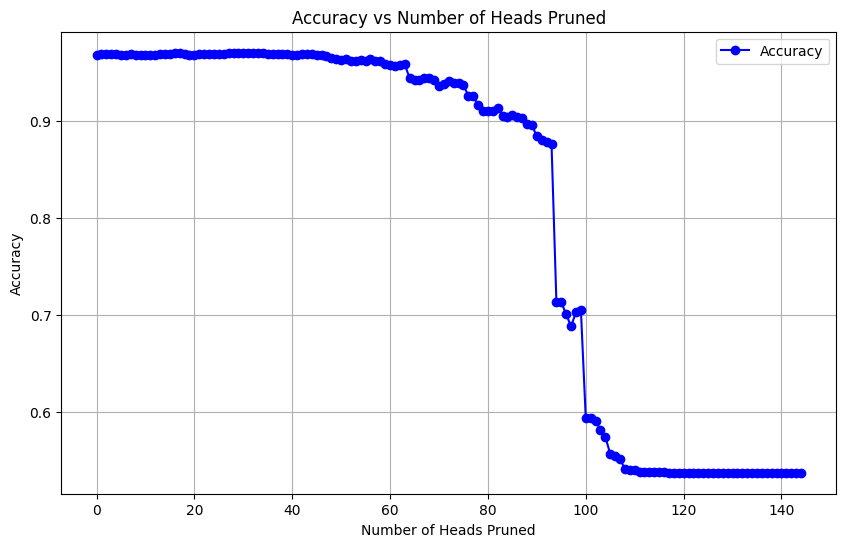

In [6]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(BERT_AE_accs)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, BERT_AE_accs, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [7]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(BERT_AE_accs))),  # 剪掉头的数量
    'Accuracy': BERT_AE_accs
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(BERT)basedonAEinverse.csv', index=False)


ALBERT的AE倒序裁剪

In [9]:
from datasets import load_dataset
import torch
from tqdm import tqdm
from textpruner import TransformerPruner
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Alireza1044/albert-base-v2-mnli")
model = AutoModelForSequenceClassification.from_pretrained("Alireza1044/albert-base-v2-mnli")
ds = load_dataset("nyu-mll/glue", "mnli")

In [10]:
def get_new_head_mask_basedonAE(head_mask_previous,AE_matrix):
    selected_matrix = head_mask_previous * (AE_matrix.max()-AE_matrix)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,size=len(ds['validation_matched']),device='cuda'):
    count = 0
    cursor = 0
    model.to(device)
    for data in tqdm(ds['validation_matched']):
        cursor += 1
        inputs = tokenizer(data['premise'],data['hypothesis'],return_tensors='pt').to(device) # 这里会自动在两个输入的语句中插入分隔符
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        if predicted_class_id == data['label']:
            count += 1
        if cursor > size:
            break
    return count / size
def prune_based_on_AE(ds,model,tokenizer,AE_matrix):
    head_mask = torch.tensor([[1]*12]*1)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(12)):
        head_mask = get_new_head_mask_basedonAE(head_mask,AE_matrix)
        model.to('cuda')
        pruner.prune(head_mask=head_mask,save_model=False)
        print('head_mask',head_mask)
        acc_score = get_acc(ds,model,tokenizer)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [11]:
ALBERT_AE_matrix = torch.load('d:\\research\\research4\ALBERT_AE\ALBERT_9815AE.pt')

C:\Users\m1830\AppData\Local\Temp\ipykernel_18152\2891418386.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ALBERT_AE_matrix = torch.load('d:\\research\\research4\ALBER

In [12]:
ALBERT_AE_accs = prune_based_on_AE(ds,model,tokenizer,torch.sum(ALBERT_AE_matrix,dim=0))

100%|██████████| 9815/9815 [00:57<00:00, 171.77it/s]


pruned heads: 0 acc: 0.8448293428425879


  0%|          | 0/12 [00:00<?, ?it/s]

head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]])


  8%|▊         | 1/12 [00:56<10:16, 56.03s/it]

pruned heads: 1 acc: 0.8440142638818136
head_mask tensor([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]])


 17%|█▋        | 2/12 [01:48<09:01, 54.16s/it]

pruned heads: 2 acc: 0.8242485990830362
head_mask tensor([[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]])


 25%|██▌       | 3/12 [02:44<08:11, 54.66s/it]

pruned heads: 3 acc: 0.7775853285787061
head_mask tensor([[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]])


 33%|███▎      | 4/12 [03:36<07:11, 53.92s/it]

pruned heads: 4 acc: 0.6883341823739175
head_mask tensor([[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]])


 42%|████▏     | 5/12 [04:34<06:27, 55.33s/it]

pruned heads: 5 acc: 0.5699439633214468
head_mask tensor([[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1]])


 50%|█████     | 6/12 [05:31<05:34, 55.72s/it]

pruned heads: 6 acc: 0.346001018848701
head_mask tensor([[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 58%|█████▊    | 7/12 [06:28<04:40, 56.13s/it]

pruned heads: 7 acc: 0.327967396841569
head_mask tensor([[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]])


 67%|██████▋   | 8/12 [07:22<03:42, 55.63s/it]

pruned heads: 8 acc: 0.3319409067753439
head_mask tensor([[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]])


 75%|███████▌  | 9/12 [08:18<02:46, 55.64s/it]

pruned heads: 9 acc: 0.3281711665817626
head_mask tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


 83%|████████▎ | 10/12 [09:11<01:49, 54.78s/it]

pruned heads: 10 acc: 0.3287824758023434
head_mask tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


 92%|█████████▏| 11/12 [10:04<00:54, 54.30s/it]d:\Python\lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


pruned heads: 11 acc: 0.35354049923586345
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


100%|██████████| 12/12 [10:47<00:00, 53.99s/it]

pruned heads: 12 acc: 0.31818644931227713


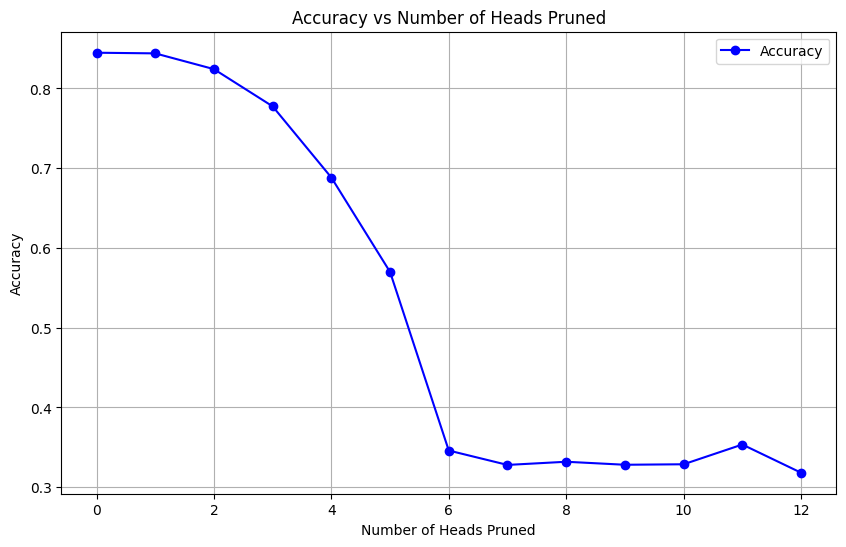

In [13]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(ALBERT_AE_accs)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, ALBERT_AE_accs, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [14]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(ALBERT_AE_accs))),  # 剪掉头的数量
    'Accuracy': ALBERT_AE_accs
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(ALBERT)basedonAEinverse.csv', index=False)


ROBERTA的AE倒序裁剪

In [15]:
from datasets import load_dataset
import torch
from tqdm import tqdm
from textpruner import TransformerPruner
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english",output_attentions=True)
ds = load_dataset("rahmaabusalma/tweets_sentiment_analysis")

In [16]:
def get_new_head_mask_basedonAE(head_mask_previous,AE_matrix):
    selected_matrix = head_mask_previous * (AE_matrix.max()-AE_matrix)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,size=len(ds['validation']),device='cuda'):
    count = 0
    cursor = 0
    model.to(device)
    for data in tqdm(ds['validation']):
        if data['label']==1:
            continue
        cursor += 1
        inputs = tokenizer(data['text'],return_tensors='pt').to(device) # 这里会自动在两个输入的语句中插入分隔符
        with torch.no_grad():
            predicted_class_id = model(**inputs)
        if torch.max(predicted_class_id[0],dim=1).indices[0] == (1 if data['label']==2 else 0):
            count += 1
        if cursor > size:
            break
    return count / size
def prune_based_on_AE(ds,model,tokenizer,AE_matrix):
    head_mask = torch.tensor([[1]*16]*24)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer,size=1000))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(384)):
        head_mask = get_new_head_mask_basedonAE(head_mask,AE_matrix)
        model.to('cuda')
        pruner.prune(head_mask=head_mask,save_model=False)
        print('head_mask',head_mask)
        acc_score = get_acc(ds,model,tokenizer,size=1000)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [17]:
ROBERTA_AE_matrix = torch.load("D:\\research\\research4\ROBERTA_AE - rectified - rectified\ROBERTA_5205AE.pt")

C:\Users\m1830\AppData\Local\Temp\ipykernel_18152\57894652.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ROBERTA_AE_matrix = torch.load("D:\\research\\research4\ROBERT

In [18]:
ROBERTA_AE_accs = prune_based_on_AE(ds,model,tokenizer,ROBERTA_AE_matrix)

 30%|███       | 1583/5205 [00:08<00:19, 188.27it/s]


pruned heads: 0 acc: 0.878


  0%|          | 0/384 [00:00<?, ?it/s]

head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    

  0%|          | 1/384 [00:08<54:30,  8.54s/it]

pruned heads: 1 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  1%|          | 2/384 [00:16<53:42,  8.44s/it]

pruned heads: 2 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  1%|          | 3/384 [00:25<55:13,  8.70s/it]

pruned heads: 3 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  1%|          | 4/384 [00:35<57:36,  9.10s/it]

pruned heads: 4 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  1%|▏         | 5/384 [00:45<58:34,  9.27s/it]

pruned heads: 5 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  2%|▏         | 6/384 [00:54<58:25,  9.27s/it]

pruned heads: 6 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  2%|▏         | 7/384 [01:03<57:11,  9.10s/it]

pruned heads: 7 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  2%|▏         | 8/384 [01:11<56:19,  8.99s/it]

pruned heads: 8 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  2%|▏         | 9/384 [01:20<55:38,  8.90s/it]

pruned heads: 9 acc: 0.883
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  3%|▎         | 10/384 [01:29<55:24,  8.89s/it]

pruned heads: 10 acc: 0.883
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  3%|▎         | 11/384 [01:38<55:23,  8.91s/it]

pruned heads: 11 acc: 0.882
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  3%|▎         | 12/384 [01:47<55:14,  8.91s/it]

pruned heads: 12 acc: 0.884
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  3%|▎         | 13/384 [01:56<54:52,  8.87s/it]

pruned heads: 13 acc: 0.884
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  4%|▎         | 14/384 [02:04<54:26,  8.83s/it]

pruned heads: 14 acc: 0.879
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  4%|▍         | 15/384 [02:13<54:06,  8.80s/it]

pruned heads: 15 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  4%|▍         | 16/384 [02:22<53:59,  8.80s/it]

pruned heads: 16 acc: 0.879
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  4%|▍         | 17/384 [02:32<55:53,  9.14s/it]

pruned heads: 17 acc: 0.879
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  5%|▍         | 18/384 [02:42<57:12,  9.38s/it]

pruned heads: 18 acc: 0.883
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  5%|▍         | 19/384 [02:52<58:15,  9.58s/it]

pruned heads: 19 acc: 0.88
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

  5%|▌         | 20/384 [03:01<56:51,  9.37s/it]

pruned heads: 20 acc: 0.882
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  5%|▌         | 21/384 [03:10<55:58,  9.25s/it]

pruned heads: 21 acc: 0.883
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  6%|▌         | 22/384 [03:19<55:13,  9.15s/it]

pruned heads: 22 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  6%|▌         | 23/384 [03:28<54:57,  9.13s/it]

pruned heads: 23 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  6%|▋         | 24/384 [03:37<55:29,  9.25s/it]

pruned heads: 24 acc: 0.879
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  7%|▋         | 25/384 [03:46<55:15,  9.23s/it]

pruned heads: 25 acc: 0.879
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  7%|▋         | 26/384 [03:56<55:06,  9.24s/it]

pruned heads: 26 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  7%|▋         | 27/384 [04:05<54:25,  9.15s/it]

pruned heads: 27 acc: 0.876
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  7%|▋         | 28/384 [04:14<53:48,  9.07s/it]

pruned heads: 28 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  8%|▊         | 29/384 [04:23<53:42,  9.08s/it]

pruned heads: 29 acc: 0.882
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  8%|▊         | 30/384 [04:33<55:16,  9.37s/it]

pruned heads: 30 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  8%|▊         | 31/384 [04:43<56:59,  9.69s/it]

pruned heads: 31 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  8%|▊         | 32/384 [04:53<57:35,  9.82s/it]

pruned heads: 32 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  9%|▊         | 33/384 [05:02<56:07,  9.59s/it]

pruned heads: 33 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  9%|▉         | 34/384 [05:11<55:06,  9.45s/it]

pruned heads: 34 acc: 0.876
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  9%|▉         | 35/384 [05:20<54:20,  9.34s/it]

pruned heads: 35 acc: 0.875
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

  9%|▉         | 36/384 [05:30<54:31,  9.40s/it]

pruned heads: 36 acc: 0.875
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 10%|▉         | 37/384 [05:40<54:34,  9.44s/it]

pruned heads: 37 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 10%|▉         | 38/384 [05:49<54:30,  9.45s/it]

pruned heads: 38 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 10%|█         | 39/384 [05:59<54:35,  9.50s/it]

pruned heads: 39 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 10%|█         | 40/384 [06:08<54:36,  9.52s/it]

pruned heads: 40 acc: 0.88
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

 11%|█         | 41/384 [06:18<55:18,  9.68s/it]

pruned heads: 41 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 11%|█         | 42/384 [06:28<55:33,  9.75s/it]

pruned heads: 42 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 11%|█         | 43/384 [06:38<55:45,  9.81s/it]

pruned heads: 43 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 11%|█▏        | 44/384 [06:48<55:29,  9.79s/it]

pruned heads: 44 acc: 0.881
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 12%|█▏        | 45/384 [06:57<54:40,  9.68s/it]

pruned heads: 45 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 12%|█▏        | 46/384 [07:07<53:52,  9.56s/it]

pruned heads: 46 acc: 0.878
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 12%|█▏        | 47/384 [07:16<53:20,  9.50s/it]

pruned heads: 47 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 12%|█▎        | 48/384 [07:25<53:04,  9.48s/it]

pruned heads: 48 acc: 0.88
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

 13%|█▎        | 49/384 [07:35<53:10,  9.52s/it]

pruned heads: 49 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 13%|█▎        | 50/384 [07:45<53:06,  9.54s/it]

pruned heads: 50 acc: 0.875
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 13%|█▎        | 51/384 [07:54<52:40,  9.49s/it]

pruned heads: 51 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 14%|█▎        | 52/384 [08:03<51:52,  9.37s/it]

pruned heads: 52 acc: 0.876
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 14%|█▍        | 53/384 [08:12<51:20,  9.31s/it]

pruned heads: 53 acc: 0.876
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 14%|█▍        | 54/384 [08:21<51:03,  9.28s/it]

pruned heads: 54 acc: 0.876
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 14%|█▍        | 55/384 [08:32<52:50,  9.64s/it]

pruned heads: 55 acc: 0.873
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 15%|█▍        | 56/384 [08:42<53:43,  9.83s/it]

pruned heads: 56 acc: 0.875
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 15%|█▍        | 57/384 [08:52<54:00,  9.91s/it]

pruned heads: 57 acc: 0.874
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 15%|█▌        | 58/384 [09:02<52:58,  9.75s/it]

pruned heads: 58 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 15%|█▌        | 59/384 [09:11<51:44,  9.55s/it]

pruned heads: 59 acc: 0.875
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 16%|█▌        | 60/384 [09:20<50:54,  9.43s/it]

pruned heads: 60 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 16%|█▌        | 61/384 [09:29<50:44,  9.42s/it]

pruned heads: 61 acc: 0.877
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 16%|█▌        | 62/384 [09:39<50:39,  9.44s/it]

pruned heads: 62 acc: 0.876
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 16%|█▋        | 63/384 [09:48<50:36,  9.46s/it]

pruned heads: 63 acc: 0.875
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 17%|█▋        | 64/384 [09:58<50:08,  9.40s/it]

pruned heads: 64 acc: 0.87
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

 17%|█▋        | 65/384 [10:07<49:37,  9.33s/it]

pruned heads: 65 acc: 0.87
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1,

 17%|█▋        | 66/384 [10:16<49:07,  9.27s/it]

pruned heads: 66 acc: 0.873
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 17%|█▋        | 67/384 [10:25<49:26,  9.36s/it]

pruned heads: 67 acc: 0.873
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 18%|█▊        | 68/384 [10:36<51:09,  9.71s/it]

pruned heads: 68 acc: 0.871
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 18%|█▊        | 69/384 [10:47<52:22,  9.98s/it]

pruned heads: 69 acc: 0.871
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 18%|█▊        | 70/384 [10:56<51:56,  9.93s/it]

pruned heads: 70 acc: 0.864
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

 18%|█▊        | 71/384 [11:06<50:59,  9.77s/it]

pruned heads: 71 acc: 0.865
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 19%|█▉        | 72/384 [11:15<50:20,  9.68s/it]

pruned heads: 72 acc: 0.865
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 19%|█▉        | 73/384 [11:25<50:07,  9.67s/it]

pruned heads: 73 acc: 0.864
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 19%|█▉        | 74/384 [11:35<50:03,  9.69s/it]

pruned heads: 74 acc: 0.863
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 20%|█▉        | 75/384 [11:45<50:47,  9.86s/it]

pruned heads: 75 acc: 0.86
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1,

 20%|█▉        | 76/384 [11:55<50:44,  9.89s/it]

pruned heads: 76 acc: 0.86
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1,

 20%|██        | 77/384 [12:04<50:17,  9.83s/it]

pruned heads: 77 acc: 0.863
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 20%|██        | 78/384 [12:14<49:54,  9.79s/it]

pruned heads: 78 acc: 0.862
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 21%|██        | 79/384 [12:24<49:45,  9.79s/it]

pruned heads: 79 acc: 0.861
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 21%|██        | 80/384 [12:34<49:31,  9.77s/it]

pruned heads: 80 acc: 0.863
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 21%|██        | 81/384 [12:44<49:36,  9.82s/it]

pruned heads: 81 acc: 0.865
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 21%|██▏       | 82/384 [12:53<49:08,  9.76s/it]

pruned heads: 82 acc: 0.863
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 22%|██▏       | 83/384 [13:03<48:36,  9.69s/it]

pruned heads: 83 acc: 0.865
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 22%|██▏       | 84/384 [13:12<48:02,  9.61s/it]

pruned heads: 84 acc: 0.864
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 22%|██▏       | 85/384 [13:23<48:57,  9.83s/it]

pruned heads: 85 acc: 0.866
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 22%|██▏       | 86/384 [13:33<49:04,  9.88s/it]

pruned heads: 86 acc: 0.86
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1,

 23%|██▎       | 87/384 [13:42<48:34,  9.81s/it]

pruned heads: 87 acc: 0.86
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1,

 23%|██▎       | 88/384 [13:52<47:43,  9.68s/it]

pruned heads: 88 acc: 0.86
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1,

 23%|██▎       | 89/384 [14:01<46:50,  9.53s/it]

pruned heads: 89 acc: 0.858
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 23%|██▎       | 90/384 [14:10<46:31,  9.50s/it]

pruned heads: 90 acc: 0.858
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 24%|██▎       | 91/384 [14:20<47:23,  9.70s/it]

pruned heads: 91 acc: 0.859
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 24%|██▍       | 92/384 [14:30<46:47,  9.62s/it]

pruned heads: 92 acc: 0.856
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 24%|██▍       | 93/384 [14:40<47:12,  9.73s/it]

pruned heads: 93 acc: 0.857
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 24%|██▍       | 94/384 [14:50<47:58,  9.93s/it]

pruned heads: 94 acc: 0.857
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 25%|██▍       | 95/384 [15:00<46:58,  9.75s/it]

pruned heads: 95 acc: 0.857
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 25%|██▌       | 96/384 [15:09<46:36,  9.71s/it]

pruned heads: 96 acc: 0.852
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 25%|██▌       | 97/384 [15:19<46:48,  9.79s/it]

pruned heads: 97 acc: 0.852
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 26%|██▌       | 98/384 [15:29<47:12,  9.90s/it]

pruned heads: 98 acc: 0.853
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 26%|██▌       | 99/384 [15:39<46:42,  9.83s/it]

pruned heads: 99 acc: 0.855
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 26%|██▌       | 100/384 [15:50<48:18, 10.20s/it]

pruned heads: 100 acc: 0.853
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 26%|██▋       | 101/384 [16:01<48:50, 10.35s/it]

pruned heads: 101 acc: 0.855
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 27%|██▋       | 102/384 [16:11<48:07, 10.24s/it]

pruned heads: 102 acc: 0.854
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 27%|██▋       | 103/384 [16:21<48:26, 10.34s/it]

pruned heads: 103 acc: 0.851
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 27%|██▋       | 104/384 [16:32<48:21, 10.36s/it]

pruned heads: 104 acc: 0.853
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 27%|██▋       | 105/384 [16:41<47:16, 10.17s/it]

pruned heads: 105 acc: 0.853
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 28%|██▊       | 106/384 [16:52<47:09, 10.18s/it]

pruned heads: 106 acc: 0.852
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 28%|██▊       | 107/384 [17:01<46:31, 10.08s/it]

pruned heads: 107 acc: 0.854
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 28%|██▊       | 108/384 [17:11<46:04, 10.02s/it]

pruned heads: 108 acc: 0.857
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 28%|██▊       | 109/384 [17:21<45:37,  9.95s/it]

pruned heads: 109 acc: 0.855
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 29%|██▊       | 110/384 [17:31<45:30,  9.97s/it]

pruned heads: 110 acc: 0.854
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 29%|██▉       | 111/384 [17:41<45:26,  9.99s/it]

pruned heads: 111 acc: 0.854
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 29%|██▉       | 112/384 [17:51<45:25, 10.02s/it]

pruned heads: 112 acc: 0.853
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 29%|██▉       | 113/384 [18:01<45:11, 10.01s/it]

pruned heads: 113 acc: 0.85
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 30%|██▉       | 114/384 [18:11<45:05, 10.02s/it]

pruned heads: 114 acc: 0.847
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 30%|██▉       | 115/384 [18:21<44:56, 10.03s/it]

pruned heads: 115 acc: 0.847
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 30%|███       | 116/384 [18:31<44:52, 10.05s/it]

pruned heads: 116 acc: 0.849
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 30%|███       | 117/384 [18:41<44:42, 10.05s/it]

pruned heads: 117 acc: 0.853
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 31%|███       | 118/384 [18:51<44:29, 10.04s/it]

pruned heads: 118 acc: 0.85
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 31%|███       | 119/384 [19:01<43:55,  9.95s/it]

pruned heads: 119 acc: 0.852
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 31%|███▏      | 120/384 [19:11<43:23,  9.86s/it]

pruned heads: 120 acc: 0.853
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 32%|███▏      | 121/384 [19:21<43:03,  9.82s/it]

pruned heads: 121 acc: 0.85
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1

 32%|███▏      | 122/384 [19:30<42:39,  9.77s/it]

pruned heads: 122 acc: 0.856
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 

 32%|███▏      | 123/384 [19:40<42:08,  9.69s/it]

pruned heads: 123 acc: 0.847
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 32%|███▏      | 124/384 [19:49<41:54,  9.67s/it]

pruned heads: 124 acc: 0.848
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 33%|███▎      | 125/384 [19:59<41:30,  9.62s/it]

pruned heads: 125 acc: 0.844
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 33%|███▎      | 126/384 [20:08<41:17,  9.60s/it]

pruned heads: 126 acc: 0.844
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 33%|███▎      | 127/384 [20:18<41:02,  9.58s/it]

pruned heads: 127 acc: 0.849
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 33%|███▎      | 128/384 [20:28<41:19,  9.69s/it]

pruned heads: 128 acc: 0.848
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 34%|███▎      | 129/384 [20:38<41:43,  9.82s/it]

pruned heads: 129 acc: 0.838
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 34%|███▍      | 130/384 [20:48<42:05,  9.94s/it]

pruned heads: 130 acc: 0.838
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 34%|███▍      | 131/384 [20:58<41:24,  9.82s/it]

pruned heads: 131 acc: 0.837
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 34%|███▍      | 132/384 [21:07<40:45,  9.70s/it]

pruned heads: 132 acc: 0.831
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 35%|███▍      | 133/384 [21:17<40:15,  9.62s/it]

pruned heads: 133 acc: 0.832
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 35%|███▍      | 134/384 [21:26<39:59,  9.60s/it]

pruned heads: 134 acc: 0.828
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 35%|███▌      | 135/384 [21:36<39:48,  9.59s/it]

pruned heads: 135 acc: 0.833
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 35%|███▌      | 136/384 [21:45<39:41,  9.60s/it]

pruned heads: 136 acc: 0.837
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 36%|███▌      | 137/384 [21:55<39:25,  9.58s/it]

pruned heads: 137 acc: 0.829
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 36%|███▌      | 138/384 [22:04<39:05,  9.53s/it]

pruned heads: 138 acc: 0.829
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 36%|███▌      | 139/384 [22:14<38:48,  9.50s/it]

pruned heads: 139 acc: 0.826
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 36%|███▋      | 140/384 [22:24<38:57,  9.58s/it]

pruned heads: 140 acc: 0.817
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 37%|███▋      | 141/384 [22:34<39:41,  9.80s/it]

pruned heads: 141 acc: 0.816
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 37%|███▋      | 142/384 [22:44<39:56,  9.90s/it]

pruned heads: 142 acc: 0.807
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 37%|███▋      | 143/384 [22:54<39:54,  9.93s/it]

pruned heads: 143 acc: 0.811
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 38%|███▊      | 144/384 [23:03<39:12,  9.80s/it]

pruned heads: 144 acc: 0.81
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 1

 38%|███▊      | 145/384 [23:13<38:49,  9.75s/it]

pruned heads: 145 acc: 0.815
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 38%|███▊      | 146/384 [23:23<39:21,  9.92s/it]

pruned heads: 146 acc: 0.815
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 38%|███▊      | 147/384 [23:33<38:48,  9.83s/it]

pruned heads: 147 acc: 0.82
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 1

 39%|███▊      | 148/384 [23:43<39:14,  9.98s/it]

pruned heads: 148 acc: 0.815
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 39%|███▉      | 149/384 [23:53<38:57,  9.95s/it]

pruned heads: 149 acc: 0.814
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 39%|███▉      | 150/384 [24:03<38:16,  9.81s/it]

pruned heads: 150 acc: 0.824
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 39%|███▉      | 151/384 [24:12<37:46,  9.73s/it]

pruned heads: 151 acc: 0.821
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 40%|███▉      | 152/384 [24:22<37:16,  9.64s/it]

pruned heads: 152 acc: 0.82
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 1

 40%|███▉      | 153/384 [24:32<38:14,  9.93s/it]

pruned heads: 153 acc: 0.821
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 40%|████      | 154/384 [24:43<38:26, 10.03s/it]

pruned heads: 154 acc: 0.82
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 1

 40%|████      | 155/384 [24:53<38:22, 10.05s/it]

pruned heads: 155 acc: 0.823
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 41%|████      | 156/384 [25:02<37:40,  9.92s/it]

pruned heads: 156 acc: 0.82
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 1

 41%|████      | 157/384 [25:12<37:03,  9.80s/it]

pruned heads: 157 acc: 0.815
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 41%|████      | 158/384 [25:21<36:46,  9.76s/it]

pruned heads: 158 acc: 0.815
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 41%|████▏     | 159/384 [25:31<36:19,  9.69s/it]

pruned heads: 159 acc: 0.823
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 42%|████▏     | 160/384 [25:40<35:55,  9.62s/it]

pruned heads: 160 acc: 0.82
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 1

 42%|████▏     | 161/384 [25:50<35:36,  9.58s/it]

pruned heads: 161 acc: 0.816
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 42%|████▏     | 162/384 [26:00<35:27,  9.58s/it]

pruned heads: 162 acc: 0.811
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 42%|████▏     | 163/384 [26:09<35:20,  9.60s/it]

pruned heads: 163 acc: 0.812
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 43%|████▎     | 164/384 [26:19<35:06,  9.58s/it]

pruned heads: 164 acc: 0.796
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 43%|████▎     | 165/384 [26:29<35:26,  9.71s/it]

pruned heads: 165 acc: 0.792
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 43%|████▎     | 166/384 [26:39<35:42,  9.83s/it]

pruned heads: 166 acc: 0.791
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 43%|████▎     | 167/384 [26:49<35:42,  9.87s/it]

pruned heads: 167 acc: 0.793
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 44%|████▍     | 168/384 [26:58<35:04,  9.74s/it]

pruned heads: 168 acc: 0.794
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 44%|████▍     | 169/384 [27:08<34:29,  9.63s/it]

pruned heads: 169 acc: 0.789
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 44%|████▍     | 170/384 [27:17<33:59,  9.53s/it]

pruned heads: 170 acc: 0.797
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 45%|████▍     | 171/384 [27:26<33:45,  9.51s/it]

pruned heads: 171 acc: 0.798
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 45%|████▍     | 172/384 [27:36<33:40,  9.53s/it]

pruned heads: 172 acc: 0.794
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 1, 0, 

 45%|████▌     | 173/384 [27:45<33:23,  9.50s/it]

pruned heads: 173 acc: 0.797
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 45%|████▌     | 174/384 [27:55<33:07,  9.47s/it]

pruned heads: 174 acc: 0.797
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 46%|████▌     | 175/384 [28:04<32:57,  9.46s/it]

pruned heads: 175 acc: 0.795
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 46%|████▌     | 176/384 [28:14<32:42,  9.44s/it]

pruned heads: 176 acc: 0.79
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1

 46%|████▌     | 177/384 [28:23<32:40,  9.47s/it]

pruned heads: 177 acc: 0.792
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 46%|████▋     | 178/384 [28:33<33:03,  9.63s/it]

pruned heads: 178 acc: 0.791
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 47%|████▋     | 179/384 [28:43<33:21,  9.76s/it]

pruned heads: 179 acc: 0.796
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 47%|████▋     | 180/384 [28:53<33:40,  9.90s/it]

pruned heads: 180 acc: 0.8
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1,

 47%|████▋     | 181/384 [29:03<33:15,  9.83s/it]

pruned heads: 181 acc: 0.793
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 47%|████▋     | 182/384 [29:13<32:53,  9.77s/it]

pruned heads: 182 acc: 0.792
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 48%|████▊     | 183/384 [29:23<32:51,  9.81s/it]

pruned heads: 183 acc: 0.795
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 48%|████▊     | 184/384 [29:33<33:07,  9.94s/it]

pruned heads: 184 acc: 0.795
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 48%|████▊     | 185/384 [29:43<32:51,  9.91s/it]

pruned heads: 185 acc: 0.788
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 48%|████▊     | 186/384 [29:53<32:43,  9.92s/it]

pruned heads: 186 acc: 0.792
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 49%|████▊     | 187/384 [30:03<32:34,  9.92s/it]

pruned heads: 187 acc: 0.785
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 49%|████▉     | 188/384 [30:12<32:24,  9.92s/it]

pruned heads: 188 acc: 0.794
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 49%|████▉     | 189/384 [30:22<32:19,  9.94s/it]

pruned heads: 189 acc: 0.791
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 49%|████▉     | 190/384 [30:32<32:02,  9.91s/it]

pruned heads: 190 acc: 0.788
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 50%|████▉     | 191/384 [30:42<31:48,  9.89s/it]

pruned heads: 191 acc: 0.796
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 50%|█████     | 192/384 [30:52<31:34,  9.87s/it]

pruned heads: 192 acc: 0.794
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 50%|█████     | 193/384 [31:02<31:12,  9.80s/it]

pruned heads: 193 acc: 0.808
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 51%|█████     | 194/384 [31:11<30:48,  9.73s/it]

pruned heads: 194 acc: 0.802
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 51%|█████     | 195/384 [31:21<30:27,  9.67s/it]

pruned heads: 195 acc: 0.798
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 51%|█████     | 196/384 [31:30<29:58,  9.56s/it]

pruned heads: 196 acc: 0.799
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 51%|█████▏    | 197/384 [31:40<29:45,  9.55s/it]

pruned heads: 197 acc: 0.807
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 52%|█████▏    | 198/384 [31:49<29:37,  9.56s/it]

pruned heads: 198 acc: 0.802
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 52%|█████▏    | 199/384 [31:59<29:18,  9.51s/it]

pruned heads: 199 acc: 0.797
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 52%|█████▏    | 200/384 [32:08<29:04,  9.48s/it]

pruned heads: 200 acc: 0.8
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1,

 52%|█████▏    | 201/384 [32:17<28:48,  9.44s/it]

pruned heads: 201 acc: 0.806
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 53%|█████▎    | 202/384 [32:27<28:56,  9.54s/it]

pruned heads: 202 acc: 0.801
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 53%|█████▎    | 203/384 [32:37<29:03,  9.63s/it]

pruned heads: 203 acc: 0.801
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 53%|█████▎    | 204/384 [32:47<29:07,  9.71s/it]

pruned heads: 204 acc: 0.802
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 53%|█████▎    | 205/384 [32:56<28:54,  9.69s/it]

pruned heads: 205 acc: 0.795
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 54%|█████▎    | 206/384 [33:06<28:32,  9.62s/it]

pruned heads: 206 acc: 0.811
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 54%|█████▍    | 207/384 [33:16<28:44,  9.74s/it]

pruned heads: 207 acc: 0.808
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 54%|█████▍    | 208/384 [33:25<28:18,  9.65s/it]

pruned heads: 208 acc: 0.811
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 54%|█████▍    | 209/384 [33:36<28:40,  9.83s/it]

pruned heads: 209 acc: 0.809
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 55%|█████▍    | 210/384 [33:46<29:01, 10.01s/it]

pruned heads: 210 acc: 0.801
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 55%|█████▍    | 211/384 [33:56<28:57, 10.04s/it]

pruned heads: 211 acc: 0.796
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 55%|█████▌    | 212/384 [34:06<28:57, 10.10s/it]

pruned heads: 212 acc: 0.798
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 55%|█████▌    | 213/384 [34:17<28:48, 10.11s/it]

pruned heads: 213 acc: 0.796
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 56%|█████▌    | 214/384 [34:27<28:46, 10.16s/it]

pruned heads: 214 acc: 0.788
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 56%|█████▌    | 215/384 [34:37<28:17, 10.05s/it]

pruned heads: 215 acc: 0.791
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 56%|█████▋    | 216/384 [34:47<28:07, 10.04s/it]

pruned heads: 216 acc: 0.797
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 57%|█████▋    | 217/384 [34:56<27:46,  9.98s/it]

pruned heads: 217 acc: 0.797
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 57%|█████▋    | 218/384 [35:06<27:11,  9.83s/it]

pruned heads: 218 acc: 0.798
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 57%|█████▋    | 219/384 [35:15<26:39,  9.69s/it]

pruned heads: 219 acc: 0.798
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 57%|█████▋    | 220/384 [35:25<26:28,  9.69s/it]

pruned heads: 220 acc: 0.787
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 58%|█████▊    | 221/384 [35:34<26:09,  9.63s/it]

pruned heads: 221 acc: 0.783
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 58%|█████▊    | 222/384 [35:44<26:05,  9.66s/it]

pruned heads: 222 acc: 0.79
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1

 58%|█████▊    | 223/384 [35:54<25:54,  9.65s/it]

pruned heads: 223 acc: 0.779
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 58%|█████▊    | 224/384 [36:04<26:04,  9.78s/it]

pruned heads: 224 acc: 0.76
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1

 59%|█████▊    | 225/384 [36:14<26:24,  9.97s/it]

pruned heads: 225 acc: 0.76
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1

 59%|█████▉    | 226/384 [36:24<26:16,  9.98s/it]

pruned heads: 226 acc: 0.761
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 59%|█████▉    | 227/384 [36:34<25:55,  9.91s/it]

pruned heads: 227 acc: 0.765
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 59%|█████▉    | 228/384 [36:44<25:40,  9.88s/it]

pruned heads: 228 acc: 0.761
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 60%|█████▉    | 229/384 [36:54<25:22,  9.83s/it]

pruned heads: 229 acc: 0.724
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 60%|█████▉    | 230/384 [37:03<24:55,  9.71s/it]

pruned heads: 230 acc: 0.722
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 60%|██████    | 231/384 [37:12<24:27,  9.59s/it]

pruned heads: 231 acc: 0.722
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 60%|██████    | 232/384 [37:22<24:14,  9.57s/it]

pruned heads: 232 acc: 0.722
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 61%|██████    | 233/384 [37:31<23:53,  9.50s/it]

pruned heads: 233 acc: 0.728
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 61%|██████    | 234/384 [37:41<23:39,  9.46s/it]

pruned heads: 234 acc: 0.708
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 61%|██████    | 235/384 [37:50<23:23,  9.42s/it]

pruned heads: 235 acc: 0.695
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 61%|██████▏   | 236/384 [37:59<23:05,  9.36s/it]

pruned heads: 236 acc: 0.679
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 62%|██████▏   | 237/384 [38:08<22:49,  9.31s/it]

pruned heads: 237 acc: 0.675
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 62%|██████▏   | 238/384 [38:17<22:35,  9.28s/it]

pruned heads: 238 acc: 0.679
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 62%|██████▏   | 239/384 [38:27<22:19,  9.24s/it]

pruned heads: 239 acc: 0.683
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 62%|██████▎   | 240/384 [38:36<22:21,  9.31s/it]

pruned heads: 240 acc: 0.688
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 63%|██████▎   | 241/384 [38:46<22:26,  9.42s/it]

pruned heads: 241 acc: 0.687
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 63%|██████▎   | 242/384 [38:55<22:08,  9.36s/it]

pruned heads: 242 acc: 0.683
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 63%|██████▎   | 243/384 [39:04<21:42,  9.24s/it]

pruned heads: 243 acc: 0.68
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 1

 64%|██████▎   | 244/384 [39:13<21:18,  9.13s/it]

pruned heads: 244 acc: 0.678
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 64%|██████▍   | 245/384 [39:22<21:00,  9.07s/it]

pruned heads: 245 acc: 0.673
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 64%|██████▍   | 246/384 [39:31<20:44,  9.02s/it]

pruned heads: 246 acc: 0.644
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 64%|██████▍   | 247/384 [39:39<20:25,  8.94s/it]

pruned heads: 247 acc: 0.648
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 1, 0, 

 65%|██████▍   | 248/384 [39:48<20:14,  8.93s/it]

pruned heads: 248 acc: 0.635
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 65%|██████▍   | 249/384 [39:57<20:00,  8.89s/it]

pruned heads: 249 acc: 0.617
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 65%|██████▌   | 250/384 [40:06<19:43,  8.83s/it]

pruned heads: 250 acc: 0.615
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 65%|██████▌   | 251/384 [40:15<19:30,  8.80s/it]

pruned heads: 251 acc: 0.618
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 66%|██████▌   | 252/384 [40:23<19:26,  8.83s/it]

pruned heads: 252 acc: 0.62
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 1

 66%|██████▌   | 253/384 [40:33<19:56,  9.13s/it]

pruned heads: 253 acc: 0.611
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 66%|██████▌   | 254/384 [40:43<20:06,  9.28s/it]

pruned heads: 254 acc: 0.614
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 66%|██████▋   | 255/384 [40:52<20:04,  9.34s/it]

pruned heads: 255 acc: 0.629
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 67%|██████▋   | 256/384 [41:01<19:37,  9.20s/it]

pruned heads: 256 acc: 0.635
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 67%|██████▋   | 257/384 [41:10<19:16,  9.10s/it]

pruned heads: 257 acc: 0.632
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 67%|██████▋   | 258/384 [41:19<18:52,  8.99s/it]

pruned heads: 258 acc: 0.65
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 1

 67%|██████▋   | 259/384 [41:28<18:38,  8.94s/it]

pruned heads: 259 acc: 0.641
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 68%|██████▊   | 260/384 [41:37<18:25,  8.92s/it]

pruned heads: 260 acc: 0.65
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 1

 68%|██████▊   | 261/384 [41:45<18:14,  8.90s/it]

pruned heads: 261 acc: 0.648
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 68%|██████▊   | 262/384 [41:54<18:04,  8.89s/it]

pruned heads: 262 acc: 0.648
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 68%|██████▊   | 263/384 [42:03<18:07,  8.99s/it]

pruned heads: 263 acc: 0.656
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 69%|██████▉   | 264/384 [42:13<18:02,  9.02s/it]

pruned heads: 264 acc: 0.655
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 69%|██████▉   | 265/384 [42:21<17:46,  8.96s/it]

pruned heads: 265 acc: 0.653
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 69%|██████▉   | 266/384 [42:30<17:33,  8.93s/it]

pruned heads: 266 acc: 0.652
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 70%|██████▉   | 267/384 [42:40<17:53,  9.18s/it]

pruned heads: 267 acc: 0.634
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 70%|██████▉   | 268/384 [42:50<18:02,  9.33s/it]

pruned heads: 268 acc: 0.631
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 70%|███████   | 269/384 [42:59<17:57,  9.37s/it]

pruned heads: 269 acc: 0.636
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 70%|███████   | 270/384 [43:08<17:28,  9.20s/it]

pruned heads: 270 acc: 0.641
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 71%|███████   | 271/384 [43:16<16:56,  8.99s/it]

pruned heads: 271 acc: 0.644
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 

 71%|███████   | 272/384 [43:25<16:30,  8.84s/it]

pruned heads: 272 acc: 0.64
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 0, 1

 71%|███████   | 273/384 [43:33<16:06,  8.70s/it]

pruned heads: 273 acc: 0.641
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 0, 

 71%|███████▏  | 274/384 [43:42<15:48,  8.62s/it]

pruned heads: 274 acc: 0.658
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 0, 

 72%|███████▏  | 275/384 [43:50<15:30,  8.53s/it]

pruned heads: 275 acc: 0.654
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 0, 

 72%|███████▏  | 276/384 [43:58<15:13,  8.46s/it]

pruned heads: 276 acc: 0.692
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 0, 

 72%|███████▏  | 277/384 [44:07<15:00,  8.42s/it]

pruned heads: 277 acc: 0.711
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 0, 

 72%|███████▏  | 278/384 [44:15<14:43,  8.33s/it]

pruned heads: 278 acc: 0.704
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 73%|███████▎  | 279/384 [44:23<14:34,  8.33s/it]

pruned heads: 279 acc: 0.705
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 73%|███████▎  | 280/384 [44:32<14:33,  8.39s/it]

pruned heads: 280 acc: 0.696
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 73%|███████▎  | 281/384 [44:40<14:27,  8.42s/it]

pruned heads: 281 acc: 0.695
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 73%|███████▎  | 282/384 [44:49<14:27,  8.51s/it]

pruned heads: 282 acc: 0.704
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 74%|███████▎  | 283/384 [44:57<14:05,  8.37s/it]

pruned heads: 283 acc: 0.706
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 74%|███████▍  | 284/384 [45:05<13:43,  8.23s/it]

pruned heads: 284 acc: 0.722
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 74%|███████▍  | 285/384 [45:13<13:25,  8.14s/it]

pruned heads: 285 acc: 0.728
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 74%|███████▍  | 286/384 [45:21<13:08,  8.05s/it]

pruned heads: 286 acc: 0.729
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 75%|███████▍  | 287/384 [45:28<12:51,  7.95s/it]

pruned heads: 287 acc: 0.722
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 75%|███████▌  | 288/384 [45:36<12:42,  7.94s/it]

pruned heads: 288 acc: 0.723
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 75%|███████▌  | 289/384 [45:44<12:33,  7.93s/it]

pruned heads: 289 acc: 0.728
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 76%|███████▌  | 290/384 [45:52<12:21,  7.88s/it]

pruned heads: 290 acc: 0.722
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 

 76%|███████▌  | 291/384 [46:00<12:11,  7.87s/it]

pruned heads: 291 acc: 0.743
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 76%|███████▌  | 292/384 [46:08<12:02,  7.85s/it]

pruned heads: 292 acc: 0.624
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 76%|███████▋  | 293/384 [46:16<12:06,  7.98s/it]

pruned heads: 293 acc: 0.662
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 77%|███████▋  | 294/384 [46:24<11:57,  7.97s/it]

pruned heads: 294 acc: 0.694
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 77%|███████▋  | 295/384 [46:32<11:57,  8.06s/it]

pruned heads: 295 acc: 0.654
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 77%|███████▋  | 296/384 [46:41<11:59,  8.18s/it]

pruned heads: 296 acc: 0.676
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 77%|███████▋  | 297/384 [46:49<11:58,  8.26s/it]

pruned heads: 297 acc: 0.635
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 78%|███████▊  | 298/384 [46:57<11:42,  8.17s/it]

pruned heads: 298 acc: 0.646
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 78%|███████▊  | 299/384 [47:05<11:40,  8.24s/it]

pruned heads: 299 acc: 0.652
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 78%|███████▊  | 300/384 [47:13<11:23,  8.13s/it]

pruned heads: 300 acc: 0.658
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 78%|███████▊  | 301/384 [47:21<11:04,  8.01s/it]

pruned heads: 301 acc: 0.541
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 79%|███████▊  | 302/384 [47:29<10:57,  8.02s/it]

pruned heads: 302 acc: 0.461
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 79%|███████▉  | 303/384 [47:37<10:39,  7.90s/it]

pruned heads: 303 acc: 0.463
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 

 79%|███████▉  | 304/384 [47:44<10:29,  7.87s/it]

pruned heads: 304 acc: 0.464
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 79%|███████▉  | 305/384 [47:52<10:17,  7.81s/it]

pruned heads: 305 acc: 0.466
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 80%|███████▉  | 306/384 [48:00<10:09,  7.82s/it]

pruned heads: 306 acc: 0.46
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 80%|███████▉  | 307/384 [48:08<10:00,  7.81s/it]

pruned heads: 307 acc: 0.46
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 80%|████████  | 308/384 [48:15<09:49,  7.76s/it]

pruned heads: 308 acc: 0.462
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 80%|████████  | 309/384 [48:23<09:39,  7.72s/it]

pruned heads: 309 acc: 0.462
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 81%|████████  | 310/384 [48:31<09:27,  7.68s/it]

pruned heads: 310 acc: 0.452
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 81%|████████  | 311/384 [48:38<09:17,  7.63s/it]

pruned heads: 311 acc: 0.452
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 81%|████████▏ | 312/384 [48:46<09:11,  7.66s/it]

pruned heads: 312 acc: 0.454
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 82%|████████▏ | 313/384 [48:53<09:01,  7.63s/it]

pruned heads: 313 acc: 0.454
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 82%|████████▏ | 314/384 [49:01<08:51,  7.59s/it]

pruned heads: 314 acc: 0.452
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 82%|████████▏ | 315/384 [49:08<08:39,  7.54s/it]

pruned heads: 315 acc: 0.452
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 82%|████████▏ | 316/384 [49:16<08:31,  7.52s/it]

pruned heads: 316 acc: 0.454
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 83%|████████▎ | 317/384 [49:23<08:23,  7.51s/it]

pruned heads: 317 acc: 0.46
head_mask tensor([[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 83%|████████▎ | 318/384 [49:31<08:15,  7.51s/it]

pruned heads: 318 acc: 0.458
head_mask tensor([[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 83%|████████▎ | 319/384 [49:38<08:06,  7.48s/it]

pruned heads: 319 acc: 0.453
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 83%|████████▎ | 320/384 [49:46<07:57,  7.45s/it]

pruned heads: 320 acc: 0.516
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 84%|████████▎ | 321/384 [49:53<07:47,  7.43s/it]

pruned heads: 321 acc: 0.526
head_mask tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 84%|████████▍ | 322/384 [50:01<07:43,  7.47s/it]

pruned heads: 322 acc: 0.529
head_mask tensor([[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 84%|████████▍ | 323/384 [50:08<07:35,  7.46s/it]

pruned heads: 323 acc: 0.458
head_mask tensor([[1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 84%|████████▍ | 324/384 [50:15<07:26,  7.44s/it]

pruned heads: 324 acc: 0.465
head_mask tensor([[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 85%|████████▍ | 325/384 [50:23<07:19,  7.45s/it]

pruned heads: 325 acc: 0.454
head_mask tensor([[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 85%|████████▍ | 326/384 [50:31<07:18,  7.56s/it]

pruned heads: 326 acc: 0.462
head_mask tensor([[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 85%|████████▌ | 327/384 [50:38<07:12,  7.58s/it]

pruned heads: 327 acc: 0.456
head_mask tensor([[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 85%|████████▌ | 328/384 [50:46<07:10,  7.69s/it]

pruned heads: 328 acc: 0.472
head_mask tensor([[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 86%|████████▌ | 329/384 [50:54<07:03,  7.69s/it]

pruned heads: 329 acc: 0.455
head_mask tensor([[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 86%|████████▌ | 330/384 [51:01<06:45,  7.52s/it]

pruned heads: 330 acc: 0.45
head_mask tensor([[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 86%|████████▌ | 331/384 [51:08<06:32,  7.41s/it]

pruned heads: 331 acc: 0.575
head_mask tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 86%|████████▋ | 332/384 [51:15<06:21,  7.33s/it]

pruned heads: 332 acc: 0.577
head_mask tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 87%|████████▋ | 333/384 [51:23<06:12,  7.30s/it]

pruned heads: 333 acc: 0.575
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 87%|████████▋ | 334/384 [51:30<06:05,  7.31s/it]

pruned heads: 334 acc: 0.59
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 87%|████████▋ | 335/384 [51:37<05:58,  7.32s/it]

pruned heads: 335 acc: 0.598
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 88%|████████▊ | 336/384 [51:44<05:49,  7.29s/it]

pruned heads: 336 acc: 0.593
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 88%|████████▊ | 337/384 [51:52<05:41,  7.27s/it]

pruned heads: 337 acc: 0.584
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 88%|████████▊ | 338/384 [51:59<05:31,  7.20s/it]

pruned heads: 338 acc: 0.583
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 88%|████████▊ | 339/384 [52:06<05:22,  7.16s/it]

pruned heads: 339 acc: 0.578
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 89%|████████▊ | 340/384 [52:13<05:13,  7.13s/it]

pruned heads: 340 acc: 0.57
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 89%|████████▉ | 341/384 [52:20<05:05,  7.11s/it]

pruned heads: 341 acc: 0.57
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 89%|████████▉ | 342/384 [52:27<05:01,  7.18s/it]

pruned heads: 342 acc: 0.573
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 89%|████████▉ | 343/384 [52:35<04:59,  7.31s/it]

pruned heads: 343 acc: 0.574
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 90%|████████▉ | 344/384 [52:42<04:55,  7.38s/it]

pruned heads: 344 acc: 0.574
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 90%|████████▉ | 345/384 [52:50<04:49,  7.43s/it]

pruned heads: 345 acc: 0.576
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 90%|█████████ | 346/384 [52:57<04:38,  7.33s/it]

pruned heads: 346 acc: 0.57
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 90%|█████████ | 347/384 [53:04<04:27,  7.24s/it]

pruned heads: 347 acc: 0.563
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 91%|█████████ | 348/384 [53:11<04:18,  7.19s/it]

pruned heads: 348 acc: 0.563
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 91%|█████████ | 349/384 [53:18<04:09,  7.13s/it]

pruned heads: 349 acc: 0.556
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 91%|█████████ | 350/384 [53:25<04:03,  7.15s/it]

pruned heads: 350 acc: 0.551
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 91%|█████████▏| 351/384 [53:33<03:57,  7.20s/it]

pruned heads: 351 acc: 0.551
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 92%|█████████▏| 352/384 [53:40<03:51,  7.23s/it]

pruned heads: 352 acc: 0.551
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 92%|█████████▏| 353/384 [53:47<03:45,  7.26s/it]

pruned heads: 353 acc: 0.551
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 92%|█████████▏| 354/384 [53:55<03:38,  7.28s/it]

pruned heads: 354 acc: 0.555
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 92%|█████████▏| 355/384 [54:02<03:31,  7.29s/it]

pruned heads: 355 acc: 0.552
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 93%|█████████▎| 356/384 [54:09<03:24,  7.31s/it]

pruned heads: 356 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 93%|█████████▎| 357/384 [54:17<03:17,  7.30s/it]

pruned heads: 357 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 93%|█████████▎| 358/384 [54:24<03:10,  7.31s/it]

pruned heads: 358 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 93%|█████████▎| 359/384 [54:31<03:02,  7.30s/it]

pruned heads: 359 acc: 0.551
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 

 94%|█████████▍| 360/384 [54:38<02:53,  7.24s/it]

pruned heads: 360 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 94%|█████████▍| 361/384 [54:45<02:45,  7.19s/it]

pruned heads: 361 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 94%|█████████▍| 362/384 [54:53<02:38,  7.21s/it]

pruned heads: 362 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 95%|█████████▍| 363/384 [55:00<02:29,  7.14s/it]

pruned heads: 363 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 95%|█████████▍| 364/384 [55:07<02:22,  7.11s/it]

pruned heads: 364 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 95%|█████████▌| 365/384 [55:14<02:14,  7.10s/it]

pruned heads: 365 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 95%|█████████▌| 366/384 [55:21<02:07,  7.09s/it]

pruned heads: 366 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 96%|█████████▌| 367/384 [55:28<01:59,  7.04s/it]

pruned heads: 367 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 96%|█████████▌| 368/384 [55:35<01:51,  6.99s/it]

pruned heads: 368 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 96%|█████████▌| 369/384 [55:41<01:44,  6.97s/it]

pruned heads: 369 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 96%|█████████▋| 370/384 [55:48<01:37,  6.93s/it]

pruned heads: 370 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 97%|█████████▋| 371/384 [55:55<01:29,  6.90s/it]

pruned heads: 371 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 97%|█████████▋| 372/384 [56:02<01:23,  6.93s/it]

pruned heads: 372 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 97%|█████████▋| 373/384 [56:09<01:16,  6.93s/it]

pruned heads: 373 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 97%|█████████▋| 374/384 [56:16<01:09,  6.95s/it]

pruned heads: 374 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 98%|█████████▊| 375/384 [56:23<01:02,  6.94s/it]

pruned heads: 375 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 98%|█████████▊| 376/384 [56:30<00:56,  7.04s/it]

pruned heads: 376 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 98%|█████████▊| 377/384 [56:38<00:49,  7.10s/it]

pruned heads: 377 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 98%|█████████▊| 378/384 [56:45<00:43,  7.17s/it]

pruned heads: 378 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 99%|█████████▊| 379/384 [56:52<00:35,  7.15s/it]

pruned heads: 379 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 99%|█████████▉| 380/384 [56:59<00:27,  7.00s/it]

pruned heads: 380 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 99%|█████████▉| 381/384 [57:05<00:20,  6.89s/it]

pruned heads: 381 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

 99%|█████████▉| 382/384 [57:12<00:13,  6.86s/it]

pruned heads: 382 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

100%|█████████▉| 383/384 [57:19<00:06,  6.80s/it]

pruned heads: 383 acc: 0.55
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0

100%|██████████| 384/384 [57:25<00:00,  8.97s/it]

pruned heads: 384 acc: 0.55


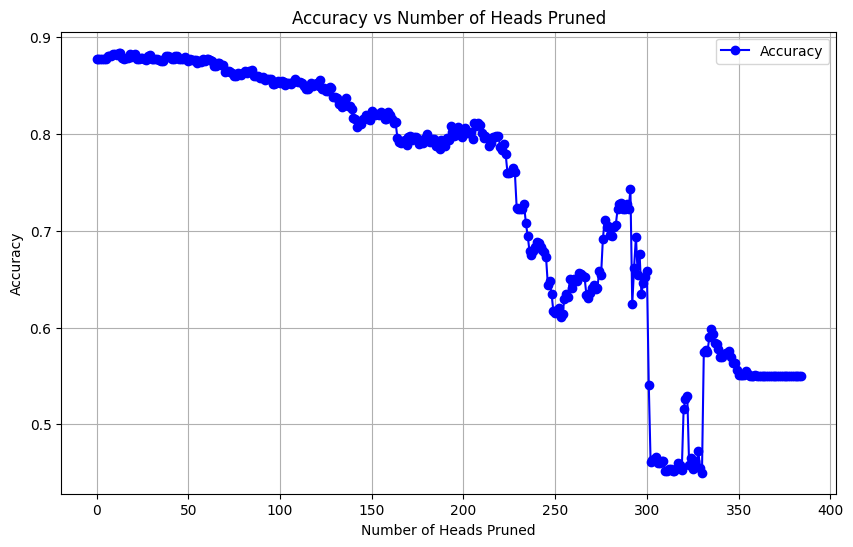

In [19]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(ROBERTA_AE_accs)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, ROBERTA_AE_accs, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [20]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(ROBERTA_AE_accs))),  # 剪掉头的数量
    'Accuracy': ROBERTA_AE_accs
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(ROBERTA)basedonAEinverse.csv', index=False)


XLM_ROBERTA的AE倒序裁剪

In [21]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
model = AutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection")
ds = load_dataset("papluca/language-identification")

In [22]:
def get_new_head_mask_basedonAE(head_mask_previous,AE_matrix):
    selected_matrix = head_mask_previous * (AE_matrix.max()-AE_matrix)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,size=len(ds['validation']),device='cuda'):
    count = 0
    id2lang = model.config.id2label
    cursor = 0
    model.to(device)
    for data in ds['validation']:
        cursor += 1
        inputs = tokenizer(data['text'], padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        preds = torch.softmax(logits, dim=-1)
        vals, idx = torch.max(preds, dim=1)
        if id2lang[idx.item()]==data['labels']:
            count += 1
        if cursor > size:
            break
    return count / size
def prune_based_on_AE(ds,model,tokenizer,AE_matrix):
    head_mask = torch.tensor([[1]*12]*12)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(144)):
        head_mask = get_new_head_mask_basedonAE(head_mask,AE_matrix)
        model.to('cuda')
        pruner.prune(head_mask=head_mask,save_model=False)
        print('head_mask',head_mask)
        acc_score = get_acc(ds,model,tokenizer)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [23]:
XLM_ROBERTA_AE_matrix = torch.load("D:\\research\\research4\XLM_ROBERTA_AE - rectified - rectified\XLM_ROBERTA_9999AE.pt")

C:\Users\m1830\AppData\Local\Temp\ipykernel_18152\3675566372.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  XLM_ROBERTA_AE_matrix = torch.load("D:\\research\\research4\

In [24]:
XLM_ROBERTA_AE_accs = prune_based_on_AE(ds,model,tokenizer,XLM_ROBERTA_AE_matrix)

pruned heads: 0 acc: 0.9973


  0%|          | 0/144 [00:00<?, ?it/s]

head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  1%|          | 1/144 [00:50<1:59:37, 50.19s/it]

pruned heads: 1 acc: 0.9974
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  1%|▏         | 2/144 [01:39<1:58:04, 49.89s/it]

pruned heads: 2 acc: 0.9974
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  2%|▏         | 3/144 [02:30<1:57:42, 50.09s/it]

pruned heads: 3 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  3%|▎         | 4/144 [03:19<1:56:33, 49.95s/it]

pruned heads: 4 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  3%|▎         | 5/144 [04:09<1:55:34, 49.89s/it]

pruned heads: 5 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  4%|▍         | 6/144 [04:58<1:53:42, 49.44s/it]

pruned heads: 6 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  5%|▍         | 7/144 [05:49<1:53:57, 49.91s/it]

pruned heads: 7 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  6%|▌         | 8/144 [06:40<1:53:53, 50.25s/it]

pruned heads: 8 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  6%|▋         | 9/144 [07:29<1:52:30, 50.00s/it]

pruned heads: 9 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  7%|▋         | 10/144 [08:19<1:51:22, 49.87s/it]

pruned heads: 10 acc: 0.9972
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  8%|▊         | 11/144 [09:08<1:49:59, 49.62s/it]

pruned heads: 11 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  8%|▊         | 12/144 [09:57<1:49:07, 49.60s/it]

pruned heads: 12 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  9%|▉         | 13/144 [10:47<1:48:20, 49.63s/it]

pruned heads: 13 acc: 0.9973
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 10%|▉         | 14/144 [11:36<1:47:24, 49.57s/it]

pruned heads: 14 acc: 0.997
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 10%|█         | 15/144 [12:28<1:47:40, 50.08s/it]

pruned heads: 15 acc: 0.997
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 11%|█         | 16/144 [13:18<1:46:55, 50.12s/it]

pruned heads: 16 acc: 0.997
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 12%|█▏        | 17/144 [14:08<1:46:08, 50.15s/it]

pruned heads: 17 acc: 0.997
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 12%|█▎        | 18/144 [14:58<1:44:53, 49.95s/it]

pruned heads: 18 acc: 0.9966
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 13%|█▎        | 19/144 [15:47<1:43:49, 49.83s/it]

pruned heads: 19 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 14%|█▍        | 20/144 [16:37<1:43:01, 49.85s/it]

pruned heads: 20 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 15%|█▍        | 21/144 [17:26<1:41:55, 49.72s/it]

pruned heads: 21 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 15%|█▌        | 22/144 [18:16<1:41:01, 49.68s/it]

pruned heads: 22 acc: 0.9964
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 16%|█▌        | 23/144 [19:07<1:41:13, 50.19s/it]

pruned heads: 23 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 17%|█▋        | 24/144 [19:57<1:40:07, 50.06s/it]

pruned heads: 24 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 17%|█▋        | 25/144 [20:47<1:39:10, 50.01s/it]

pruned heads: 25 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 18%|█▊        | 26/144 [21:36<1:37:37, 49.64s/it]

pruned heads: 26 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 19%|█▉        | 27/144 [22:26<1:37:08, 49.82s/it]

pruned heads: 27 acc: 0.9965
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 19%|█▉        | 28/144 [23:16<1:36:10, 49.75s/it]

pruned heads: 28 acc: 0.9966
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 20%|██        | 29/144 [24:07<1:36:32, 50.37s/it]

pruned heads: 29 acc: 0.9966
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 21%|██        | 30/144 [24:58<1:35:56, 50.50s/it]

pruned heads: 30 acc: 0.9966
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 22%|██▏       | 31/144 [25:52<1:36:52, 51.44s/it]

pruned heads: 31 acc: 0.9966
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 22%|██▏       | 32/144 [26:42<1:35:06, 50.95s/it]

pruned heads: 32 acc: 0.9966
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 23%|██▎       | 33/144 [27:32<1:33:38, 50.62s/it]

pruned heads: 33 acc: 0.9961
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 24%|██▎       | 34/144 [28:22<1:32:53, 50.67s/it]

pruned heads: 34 acc: 0.9963
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 24%|██▍       | 35/144 [29:11<1:31:01, 50.11s/it]

pruned heads: 35 acc: 0.9963
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 25%|██▌       | 36/144 [30:00<1:29:20, 49.63s/it]

pruned heads: 36 acc: 0.9962
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 26%|██▌       | 37/144 [30:50<1:29:05, 49.96s/it]

pruned heads: 37 acc: 0.9961
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 26%|██▋       | 38/144 [31:42<1:29:02, 50.40s/it]

pruned heads: 38 acc: 0.9962
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 27%|██▋       | 39/144 [32:33<1:28:26, 50.54s/it]

pruned heads: 39 acc: 0.9964
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 28%|██▊       | 40/144 [33:23<1:27:18, 50.37s/it]

pruned heads: 40 acc: 0.9964
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 28%|██▊       | 41/144 [34:14<1:26:56, 50.64s/it]

pruned heads: 41 acc: 0.9961
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 29%|██▉       | 42/144 [35:03<1:25:12, 50.13s/it]

pruned heads: 42 acc: 0.996
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 30%|██▉       | 43/144 [35:53<1:24:09, 50.00s/it]

pruned heads: 43 acc: 0.9963
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 31%|███       | 44/144 [36:43<1:23:26, 50.07s/it]

pruned heads: 44 acc: 0.9962
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 31%|███▏      | 45/144 [37:33<1:22:47, 50.17s/it]

pruned heads: 45 acc: 0.9962
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 32%|███▏      | 46/144 [38:23<1:21:50, 50.10s/it]

pruned heads: 46 acc: 0.9959
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 33%|███▎      | 47/144 [39:13<1:20:44, 49.94s/it]

pruned heads: 47 acc: 0.9958
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 33%|███▎      | 48/144 [40:03<1:19:54, 49.94s/it]

pruned heads: 48 acc: 0.9958
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 34%|███▍      | 49/144 [40:51<1:18:22, 49.50s/it]

pruned heads: 49 acc: 0.996
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 35%|███▍      | 50/144 [41:40<1:17:03, 49.18s/it]

pruned heads: 50 acc: 0.9958
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 35%|███▌      | 51/144 [42:29<1:16:28, 49.34s/it]

pruned heads: 51 acc: 0.9957
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 36%|███▌      | 52/144 [43:19<1:15:52, 49.48s/it]

pruned heads: 52 acc: 0.9956
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 37%|███▋      | 53/144 [44:09<1:15:12, 49.59s/it]

pruned heads: 53 acc: 0.9956
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 38%|███▊      | 54/144 [44:58<1:14:13, 49.48s/it]

pruned heads: 54 acc: 0.9957
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 38%|███▊      | 55/144 [45:47<1:13:04, 49.27s/it]

pruned heads: 55 acc: 0.9956
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 39%|███▉      | 56/144 [46:36<1:12:17, 49.28s/it]

pruned heads: 56 acc: 0.9956
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 40%|███▉      | 57/144 [47:25<1:11:20, 49.20s/it]

pruned heads: 57 acc: 0.9955
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 40%|████      | 58/144 [48:16<1:11:17, 49.74s/it]

pruned heads: 58 acc: 0.9955
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 41%|████      | 59/144 [49:05<1:10:11, 49.55s/it]

pruned heads: 59 acc: 0.9954
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 42%|████▏     | 60/144 [49:56<1:09:54, 49.93s/it]

pruned heads: 60 acc: 0.9952
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 42%|████▏     | 61/144 [50:45<1:08:45, 49.71s/it]

pruned heads: 61 acc: 0.9954
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 43%|████▎     | 62/144 [51:34<1:07:25, 49.33s/it]

pruned heads: 62 acc: 0.9955
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 44%|████▍     | 63/144 [52:23<1:06:37, 49.35s/it]

pruned heads: 63 acc: 0.9954
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 44%|████▍     | 64/144 [53:12<1:05:34, 49.18s/it]

pruned heads: 64 acc: 0.9956
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 45%|████▌     | 65/144 [54:03<1:05:20, 49.63s/it]

pruned heads: 65 acc: 0.9955
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 46%|████▌     | 66/144 [54:50<1:03:33, 48.89s/it]

pruned heads: 66 acc: 0.9951
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 47%|████▋     | 67/144 [55:38<1:02:37, 48.80s/it]

pruned heads: 67 acc: 0.9952
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 47%|████▋     | 68/144 [56:29<1:02:28, 49.32s/it]

pruned heads: 68 acc: 0.9951
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 48%|████▊     | 69/144 [57:19<1:01:43, 49.38s/it]

pruned heads: 69 acc: 0.9949
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 49%|████▊     | 70/144 [58:09<1:01:27, 49.83s/it]

pruned heads: 70 acc: 0.995
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 49%|████▉     | 71/144 [58:57<59:59, 49.31s/it]  

pruned heads: 71 acc: 0.9951
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 50%|█████     | 72/144 [59:47<59:10, 49.31s/it]

pruned heads: 72 acc: 0.995
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 51%|█████     | 73/144 [1:00:37<58:38, 49.55s/it]

pruned heads: 73 acc: 0.9948
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 51%|█████▏    | 74/144 [1:01:25<57:25, 49.23s/it]

pruned heads: 74 acc: 0.9948
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 52%|█████▏    | 75/144 [1:02:15<56:40, 49.28s/it]

pruned heads: 75 acc: 0.995
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 53%|█████▎    | 76/144 [1:03:04<55:47, 49.22s/it]

pruned heads: 76 acc: 0.995
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 53%|█████▎    | 77/144 [1:03:53<54:58, 49.23s/it]

pruned heads: 77 acc: 0.9949
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 54%|█████▍    | 78/144 [1:04:42<54:05, 49.18s/it]

pruned heads: 78 acc: 0.995
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 55%|█████▍    | 79/144 [1:05:31<53:10, 49.09s/it]

pruned heads: 79 acc: 0.9949
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 56%|█████▌    | 80/144 [1:06:20<52:16, 49.01s/it]

pruned heads: 80 acc: 0.9947
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 56%|█████▋    | 81/144 [1:07:08<51:16, 48.83s/it]

pruned heads: 81 acc: 0.9948
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 57%|█████▋    | 82/144 [1:07:57<50:30, 48.88s/it]

pruned heads: 82 acc: 0.9948
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 58%|█████▊    | 83/144 [1:08:45<49:25, 48.62s/it]

pruned heads: 83 acc: 0.994
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 58%|█████▊    | 84/144 [1:09:33<48:18, 48.31s/it]

pruned heads: 84 acc: 0.994
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 59%|█████▉    | 85/144 [1:10:20<47:11, 47.99s/it]

pruned heads: 85 acc: 0.9941
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 60%|█████▉    | 86/144 [1:11:06<45:53, 47.47s/it]

pruned heads: 86 acc: 0.9942
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 60%|██████    | 87/144 [1:11:53<44:44, 47.09s/it]

pruned heads: 87 acc: 0.9931
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 61%|██████    | 88/144 [1:12:39<43:46, 46.90s/it]

pruned heads: 88 acc: 0.9931
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 62%|██████▏   | 89/144 [1:13:25<42:51, 46.76s/it]

pruned heads: 89 acc: 0.9933
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 62%|██████▎   | 90/144 [1:14:13<42:13, 46.92s/it]

pruned heads: 90 acc: 0.9924
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 63%|██████▎   | 91/144 [1:15:00<41:27, 46.92s/it]

pruned heads: 91 acc: 0.9925
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 64%|██████▍   | 92/144 [1:15:47<40:52, 47.16s/it]

pruned heads: 92 acc: 0.9697
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 65%|██████▍   | 93/144 [1:16:34<39:54, 46.96s/it]

pruned heads: 93 acc: 0.9628
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 65%|██████▌   | 94/144 [1:17:21<39:09, 47.00s/it]

pruned heads: 94 acc: 0.9609
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 66%|██████▌   | 95/144 [1:18:09<38:37, 47.30s/it]

pruned heads: 95 acc: 0.9604
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 67%|██████▋   | 96/144 [1:18:56<37:40, 47.09s/it]

pruned heads: 96 acc: 0.9581
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 67%|██████▋   | 97/144 [1:19:41<36:32, 46.64s/it]

pruned heads: 97 acc: 0.9479
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 68%|██████▊   | 98/144 [1:20:27<35:28, 46.27s/it]

pruned heads: 98 acc: 0.9165
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 69%|██████▉   | 99/144 [1:21:10<34:02, 45.38s/it]

pruned heads: 99 acc: 0.7396
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 69%|██████▉   | 100/144 [1:21:54<33:03, 45.09s/it]

pruned heads: 100 acc: 0.7365
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 70%|███████   | 101/144 [1:22:37<31:41, 44.22s/it]

pruned heads: 101 acc: 0.6889
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 71%|███████   | 102/144 [1:23:18<30:18, 43.29s/it]

pruned heads: 102 acc: 0.6215
head_mask tensor([[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 72%|███████▏  | 103/144 [1:23:59<29:12, 42.74s/it]

pruned heads: 103 acc: 0.4977
head_mask tensor([[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 72%|███████▏  | 104/144 [1:24:42<28:27, 42.68s/it]

pruned heads: 104 acc: 0.499
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 73%|███████▎  | 105/144 [1:25:25<27:51, 42.87s/it]

pruned heads: 105 acc: 0.4869
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 74%|███████▎  | 106/144 [1:26:08<27:11, 42.93s/it]

pruned heads: 106 acc: 0.469
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 74%|███████▍  | 107/144 [1:26:49<26:12, 42.49s/it]

pruned heads: 107 acc: 0.2455
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 75%|███████▌  | 108/144 [1:27:31<25:23, 42.33s/it]

pruned heads: 108 acc: 0.2543
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 76%|███████▌  | 109/144 [1:28:14<24:44, 42.40s/it]

pruned heads: 109 acc: 0.1723
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 76%|███████▋  | 110/144 [1:28:56<23:54, 42.19s/it]

pruned heads: 110 acc: 0.1644
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 77%|███████▋  | 111/144 [1:29:36<22:55, 41.67s/it]

pruned heads: 111 acc: 0.1512
head_mask tensor([[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 78%|███████▊  | 112/144 [1:30:18<22:17, 41.80s/it]

pruned heads: 112 acc: 0.0939
head_mask tensor([[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 78%|███████▊  | 113/144 [1:31:00<21:33, 41.73s/it]

pruned heads: 113 acc: 0.0806
head_mask tensor([[0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 79%|███████▉  | 114/144 [1:31:40<20:38, 41.30s/it]

pruned heads: 114 acc: 0.0662
head_mask tensor([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 80%|███████▉  | 115/144 [1:32:23<20:13, 41.86s/it]

pruned heads: 115 acc: 0.0529
head_mask tensor([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 81%|████████  | 116/144 [1:33:05<19:29, 41.77s/it]

pruned heads: 116 acc: 0.05
head_mask tensor([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 81%|████████▏ | 117/144 [1:33:45<18:37, 41.38s/it]

pruned heads: 117 acc: 0.0501
head_mask tensor([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 82%|████████▏ | 118/144 [1:34:26<17:51, 41.23s/it]

pruned heads: 118 acc: 0.0502
head_mask tensor([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 83%|████████▎ | 119/144 [1:35:07<17:05, 41.03s/it]

pruned heads: 119 acc: 0.0501
head_mask tensor([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 83%|████████▎ | 120/144 [1:35:47<16:18, 40.78s/it]

pruned heads: 120 acc: 0.0501
head_mask tensor([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 84%|████████▍ | 121/144 [1:36:29<15:50, 41.31s/it]

pruned heads: 121 acc: 0.0501
head_mask tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 85%|████████▍ | 122/144 [1:37:10<15:05, 41.16s/it]

pruned heads: 122 acc: 0.0501
head_mask tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 85%|████████▌ | 123/144 [1:37:52<14:24, 41.19s/it]

pruned heads: 123 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 86%|████████▌ | 124/144 [1:38:32<13:39, 40.98s/it]

pruned heads: 124 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])


 87%|████████▋ | 125/144 [1:39:11<12:46, 40.37s/it]

pruned heads: 125 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]])


 88%|████████▊ | 126/144 [1:39:50<11:59, 39.99s/it]

pruned heads: 126 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]])


 88%|████████▊ | 127/144 [1:40:30<11:17, 39.86s/it]

pruned heads: 127 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]])


 89%|████████▉ | 128/144 [1:41:08<10:28, 39.30s/it]

pruned heads: 128 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]])


 90%|████████▉ | 129/144 [1:41:46<09:47, 39.15s/it]

pruned heads: 129 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]])


 90%|█████████ | 130/144 [1:42:24<09:02, 38.78s/it]

pruned heads: 130 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]])


 91%|█████████ | 131/144 [1:43:03<08:21, 38.59s/it]

pruned heads: 131 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]])


 92%|█████████▏| 132/144 [1:43:41<07:43, 38.65s/it]

pruned heads: 132 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]])


 92%|█████████▏| 133/144 [1:44:20<07:04, 38.63s/it]

pruned heads: 133 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]])


 93%|█████████▎| 134/144 [1:44:58<06:24, 38.47s/it]

pruned heads: 134 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]])


 94%|█████████▍| 135/144 [1:45:36<05:44, 38.23s/it]

pruned heads: 135 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]])


 94%|█████████▍| 136/144 [1:46:14<05:06, 38.28s/it]

pruned heads: 136 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]])


 95%|█████████▌| 137/144 [1:46:52<04:26, 38.04s/it]

pruned heads: 137 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


 96%|█████████▌| 138/144 [1:47:30<03:48, 38.14s/it]

pruned heads: 138 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 139/144 [1:48:09<03:12, 38.56s/it]

pruned heads: 139 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 140/144 [1:48:47<02:33, 38.29s/it]

pruned heads: 140 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 98%|█████████▊| 141/144 [1:49:26<01:55, 38.43s/it]

pruned heads: 141 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▊| 142/144 [1:50:04<01:16, 38.44s/it]

pruned heads: 142 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▉| 143/144 [1:50:41<00:38, 38.01s/it]

pruned heads: 143 acc: 0.05
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


100%|██████████| 144/144 [1:51:16<00:00, 46.37s/it]

pruned heads: 144 acc: 0.05


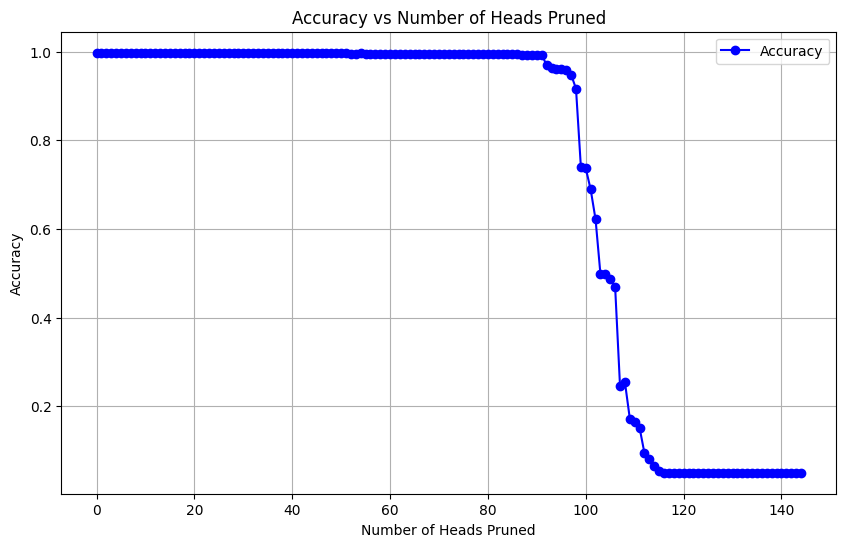

In [25]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(XLM_ROBERTA_AE_accs)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, XLM_ROBERTA_AE_accs, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [26]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(XLM_ROBERTA_AE_accs))),  # 剪掉头的数量
    'Accuracy': XLM_ROBERTA_AE_accs
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(XLM_ROBERTA)basedonAEinverse.csv', index=False)
